# Fallback - Insert Retention Scores MLB-Rays
* StellarAlgo Data Science
* Ryan Kazmerik, Grant Donst
* Sept 29, 2022

In [32]:
import boto3
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from datetime import datetime
from pytz import timezone
from pycaret.classification import *
from shared_utilities import helpers

In [33]:
if not boto3.DEFAULT_SESSION:
    ! aws sso login --profile Stellaralgo-DataScienceAdmin
    session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')

In [34]:
LKUPCLIENTID = "45"
DBNAME = "stlrrays"
ENV = "qa-app"
SCORINGYEAR = 2022

In [35]:
df = helpers.get_retention_dataset(
    cluster = "prod-app",
    database = DBNAME,
    lkupclientid = LKUPCLIENTID,
    start_year = 2010,
    end_year = 2022
)

df.shape

Authorized as AROASQ4JELIXYLYV6P4UV:gdonst@stellaralgo.com


(11209, 24)

In [36]:
df.year.value_counts()

2022    3115
2021    2593
2017    1839
2019    1838
2018    1824
Name: year, dtype: int64

In [37]:
df.head()

,lkupclientid,clientcode,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,tenure,disttovenue,recency,missed_games_1,missed_games_2,missed_games_over_2,forward_records,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer
0,45,RAYS,6594,2022,Full Season,8170.0,2022-09-24,0.84,168,8395,2126,31.01,0,9,2,0,146,1.07,0.02,0.02,Unknown,0,0,0
1,45,RAYS,55174,2021,Membership Silver,4000.0,1970-01-01,0.00,155,5475,1669,31.01,0,1,0,0,0,0.09,0.16,1.70,Unknown,0,0,0
2,45,RAYS,64681,2022,Membership Bronze,500.0,1970-01-01,0.00,284,365,308,361.99,0,0,0,0,0,1.04,0.00,0.00,Unknown,0,0,0
3,45,RAYS,115151,2018,Full Season,7124.0,2018-09-30,0.82,64,9855,670,1.42,0,9,2,1,24,0.51,0.05,0.09,Unknown,2,0,1
4,45,RAYS,115151,2022,Full Season,8170.0,2022-09-24,0.88,168,9855,2126,1.42,0,7,0,1,44,2.61,0.29,0.11,Unknown,0,0,0


### We should specify the features used in our model:

In [38]:
# choose the features for the stellar base retention model
features = [
    "isnextyear_buyer",
    "recentdate",
    "clientcode",
	"dimcustomermasterid",
	"lkupclientid",
	"productgrouping",
	"year",
	"attendancepercent",
    "clicktoopenratio",
    "clicktosendratio",
    "disttovenue",
    "inperson_contact",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "opentosendratio",
    "phonecall",
    "recency",
    "renewedbeforedays",
    "source_tenure",
    "totalspent"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] < SCORINGYEAR]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (6880, 21)
Unseen Data For Predictions: (1214, 21)



In [39]:
print(df_dataset.year.value_counts())

2021    2593
2017    1839
2019    1838
2018    1824
Name: year, dtype: int64


### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [40]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentdate"
    ],
    ignore_features=[
        "clientcode",
		"dimcustomermasterid",
		"lkupclientid",
		"productgrouping",
		"year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancepercent",
        "clicktoopenratio",
        "clicktosendratio",
        "disttovenue",
        "inperson_contact",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "opentosendratio",
        "phonecall",
        "recency",
        "renewedbeforedays",
        "source_tenure",
        "totalspent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [41]:
model_matrix = compare_models(
    fold= 10,
    include= ["gbc","lightgbm","lr","rf","xgboost"],
    n_select=5,
    probability_threshold= 0.75
)
results = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7127,0.7988,0.6891,0.8674,0.7679,0.4036,0.4224,1.0430
xgboost,Extreme Gradient Boosting,0.7053,0.7813,0.6900,0.8551,0.7637,0.3840,0.3999,0.1280
lightgbm,Light Gradient Boosting Machine,0.7050,0.7922,0.6757,0.8678,0.7597,0.3926,0.4138,0.1730
rf,Random Forest Classifier,0.6954,0.7840,0.6682,0.8593,0.7516,0.3733,0.3936,0.0860
lr,Logistic Regression,0.6819,0.7434,0.6514,0.8531,0.7385,0.3505,0.3718,0.2140


In [42]:
models = []
for idx, m in enumerate(model_matrix):
    
    model = create_model(m)
    final_model = finalize_model(model)
    
    models.append({
        "name": str(results.iloc[idx]["Model"]),
        "model": final_model
    })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6906,0.7514,0.6609,0.8585,0.7469,0.3659,0.3870
1,0.7179,0.7983,0.6782,0.8867,0.7686,0.4235,0.4490
2,0.6752,0.7313,0.6485,0.8452,0.7339,0.3353,0.3550
3,0.6923,0.7342,0.6832,0.8415,0.7541,0.3548,0.3687
4,0.6496,0.7283,0.6015,0.8467,0.7033,0.3041,0.3314
5,0.6769,0.7381,0.6485,0.8479,0.7349,0.3396,0.3601
6,0.6667,0.7108,0.6402,0.8377,0.7257,0.3197,0.3389
7,0.6781,0.7251,0.6476,0.8502,0.7352,0.3433,0.3644
8,0.6918,0.7653,0.6526,0.8680,0.7450,0.3746,0.3995


/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Let's load in our 2021 season data and get retention scores using the model:

In [43]:
df_inference = df.loc[df["year"] >= SCORINGYEAR]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(3115, 21)

In [44]:
predictions = []
for idx, final_m in enumerate(models):
    
    df_predictions = (predict_model(final_m['model'], data=df_inference, raw_score=True))
    df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]
    final_m["predictions"] = df_predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7002,0,0.0000,0.0000,0.0000,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.6302,0,0.0000,0.0000,0.0000,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6543,0,0.0000,0.0000,0.0000,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7098,0,0.0000,0.0000,0.0000,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6507,0,0.0000,0.0000,0.0000,0.0000,0.0000


### We can create some histograms to visualize each model distribution:

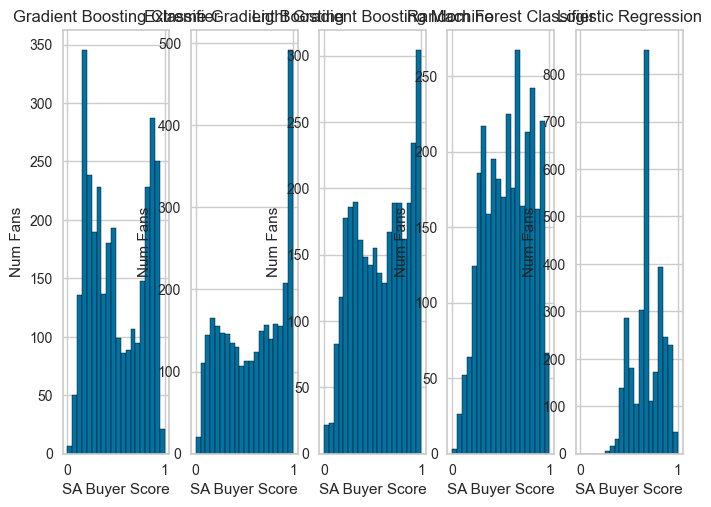

In [45]:
for idx, model in enumerate(models):
    
    plt.subplot(1, 5, idx+1)
    plt.title(model["name"])
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")
    plt.hist(model["predictions"]["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### We can also see how many purchases there are in each range of scores:

In [46]:
for idx, model in enumerate(models):
    print(models[idx]["predictions"]["Label"].value_counts())


0    2180
1     934
Name: Label, dtype: int64
0    1916
1    1152
Name: Label, dtype: int64
0    2028
1    1077
Name: Label, dtype: int64
0    2210
1     904
Name: Label, dtype: int64
0    2027
1    1088
Name: Label, dtype: int64


### Select the model you would like to use for updating scores:

In [47]:
selected_model = "Light Gradient Boosting Machine"

for model in models:
    if model["name"] == selected_model:
        df_scores = model["predictions"]
                                 
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3105 entries, 0 to 11159
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   isnextyear_buyer     3105 non-null   int64         
 1   recentdate           3105 non-null   datetime64[ns]
 2   clientcode           3105 non-null   object        
 3   dimcustomermasterid  3105 non-null   int64         
 4   lkupclientid         3105 non-null   int64         
 5   productgrouping      3105 non-null   object        
 6   year                 3105 non-null   int64         
 7   attendancepercent    3105 non-null   float64       
 8   clicktoopenratio     3105 non-null   object        
 9   clicktosendratio     3105 non-null   object        
 10  disttovenue          3105 non-null   float64       
 11  inperson_contact     3105 non-null   int64         
 12  missed_games_1       3105 non-null   object        
 13  missed_games_2       3105 non-nu

### Optionally we can push these scores into QA so that we can see what the new scoring looks like in the CDP:

In [48]:
CONN = helpers.get_redshift_connection(ENV, DBNAME)

Authorized as AROASQ4JELIXYLYV6P4UV:gdonst@stellaralgo.com


### Insert the scores into the customerretentionscores table in RedShift:

In [49]:
cur = CONN.cursor()

batch_size = 100
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE: {DBNAME} ({LKUPCLIENTID})")

fields = f"""
INSERT INTO {DBNAME}.dw.customerretentionscores (
    attendancePercentage,
    dimcustomermasterid,
    scoredate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonyear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        values = f"""
            (
                {str(row.attendancepercent)},
                {str(row.dimcustomermasterid)},
                '{str(datetime.now().strftime("%Y-%m-%d"))}',
                {str(row.lkupclientid)},
                '{str(row.recentdate)}',
                '{str(row.productgrouping)}',
                {str(round((row.Score_1*100),4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    cur.execute(insert_statement)
    CONN.commit()

    count = cur.rowcount
        
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING 3115 NEW RETENTION SCORES TO DATABASE: stlrrays (45)
 > INSERTED BATCH 1 : ROWS 1 - 100
 > INSERTED BATCH 2 : ROWS 101 - 200
 > INSERTED BATCH 3 : ROWS 201 - 300
 > INSERTED BATCH 4 : ROWS 301 - 400
 > INSERTED BATCH 5 : ROWS 401 - 500
 > INSERTED BATCH 6 : ROWS 501 - 600
 > INSERTED BATCH 7 : ROWS 601 - 700
 > INSERTED BATCH 8 : ROWS 701 - 800
 > INSERTED BATCH 9 : ROWS 801 - 900
 > INSERTED BATCH 10 : ROWS 901 - 1000
 > INSERTED BATCH 11 : ROWS 1001 - 1100
 > INSERTED BATCH 12 : ROWS 1101 - 1200
 > INSERTED BATCH 13 : ROWS 1201 - 1300
 > INSERTED BATCH 14 : ROWS 1301 - 1400
 > INSERTED BATCH 15 : ROWS 1401 - 1500
 > INSERTED BATCH 16 : ROWS 1501 - 1600
 > INSERTED BATCH 17 : ROWS 1601 - 1700
 > INSERTED BATCH 18 : ROWS 1701 - 1800
 > INSERTED BATCH 19 : ROWS 1801 - 1900
 > INSERTED BATCH 20 : ROWS 1901 - 2000
 > INSERTED BATCH 21 : ROWS 2001 - 2100
 > INSERTED BATCH 22 : ROWS 2101 - 2200
 > INSERTED BATCH 23 : ROWS 2201 - 2300
 > INSERTED BATCH 24 : ROWS 2301 - 2400
 > INSE